In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_20591/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
# provider.backends()

DEBUG_PRINT = True

backend = provider.get_backend('ibm_osaka') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = 1

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fa643946280>
backend_name
ibm_osaka
backend_version
1.1.4
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [11

## RR Dispersive Shift (Chi)

In [4]:
from exp_classes.device_charecterisation import RRFreqSpec

chi_exp = RRFreqSpec(
    qubit=qubit,
    backend=backend,
    freq_span=4.0 * MHz,
    num_experiments=81,
    fit_func_name='gaussian',
    chi_est=1. * MHz
)

In [5]:
chi_jobs, chi_info = chi_exp.get_jobs()

chi_info

{'Total Experiment Size': 162,
 'Frequency Step Size (MHz)': 0.05,
 'Frequency Span (MHz)': 4.0}

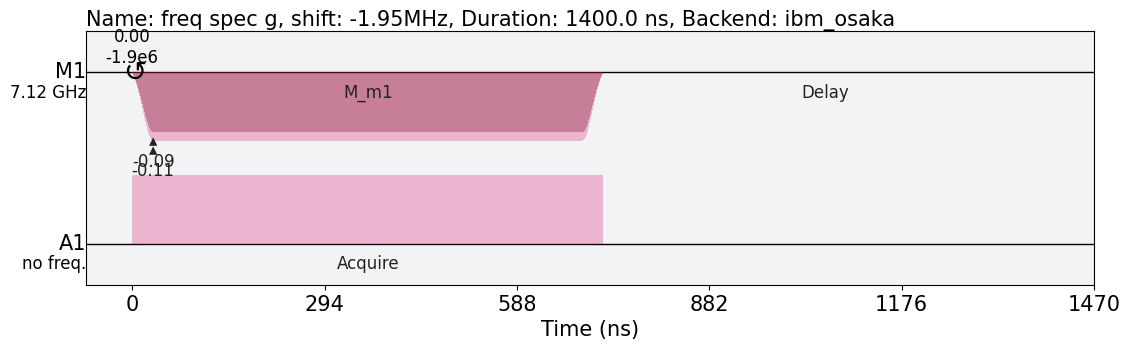

In [6]:
chi_jobs[1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Standard Fidelity Experiment

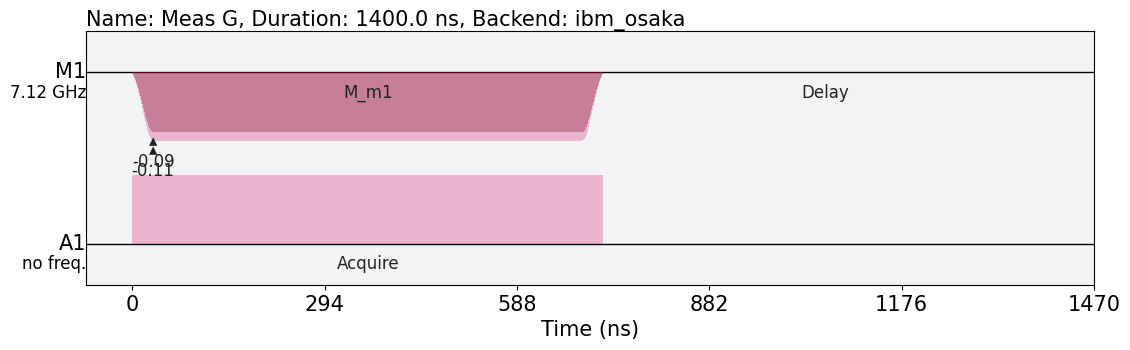

In [7]:
from exp_classes.device_charecterisation import StandardMeas

meas_exp = StandardMeas(qubit, backend)
meas_jobs = meas_exp.get_jobs()

meas_jobs[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Acquisition Scan Experiment

In [8]:
from exp_classes.device_charecterisation import StandardAcqScanExp
from utils import get_dt_from

acq_latency_dt = get_dt_from(300 * ns, dt)

acq_exp = StandardAcqScanExp(
    qubit=qubit,
    backend=backend,
    acq_latency_dt=acq_latency_dt,
    acq_start_dt=get_dt_from(0. * ns, dt),
    acq_end_dt=measure_pulse.duration + measure_delay.duration + acq_latency_dt,
    num_acq_exp=141,
    acq_meas_dur_dt=get_dt_from(16. * ns, dt)
)

acq_jobs, acq_info = acq_exp.get_jobs()

acq_info

{'Total Experiment Size': 282,
 'Acquisition Latency (ns)': 304.0,
 'Acquisition Start Delay (ns)': 0.0,
 'Acquisition End Delay (ns)': 1704.0,
 'Acquisition Duration (ns)': 16.0}

In [9]:
print(acq_exp.acq_delay_linspace_ns/ns)

[   0.           12.17142857   24.34285714   36.51428571   48.68571429
   60.85714286   73.02857143   85.2          97.37142857  109.54285714
  121.71428571  133.88571429  146.05714286  158.22857143  170.4
  182.57142857  194.74285714  206.91428571  219.08571429  231.25714286
  243.42857143  255.6         267.77142857  279.94285714  292.11428571
  304.28571429  316.45714286  328.62857143  340.8         352.97142857
  365.14285714  377.31428571  389.48571429  401.65714286  413.82857143
  426.          438.17142857  450.34285714  462.51428571  474.68571429
  486.85714286  499.02857143  511.2         523.37142857  535.54285714
  547.71428571  559.88571429  572.05714286  584.22857143  596.4
  608.57142857  620.74285714  632.91428571  645.08571429  657.25714286
  669.42857143  681.6         693.77142857  705.94285714  718.11428571
  730.28571429  742.45714286  754.62857143  766.8         778.97142857
  791.14285714  803.31428571  815.48571429  827.65714286  839.82857143
  852.          864.

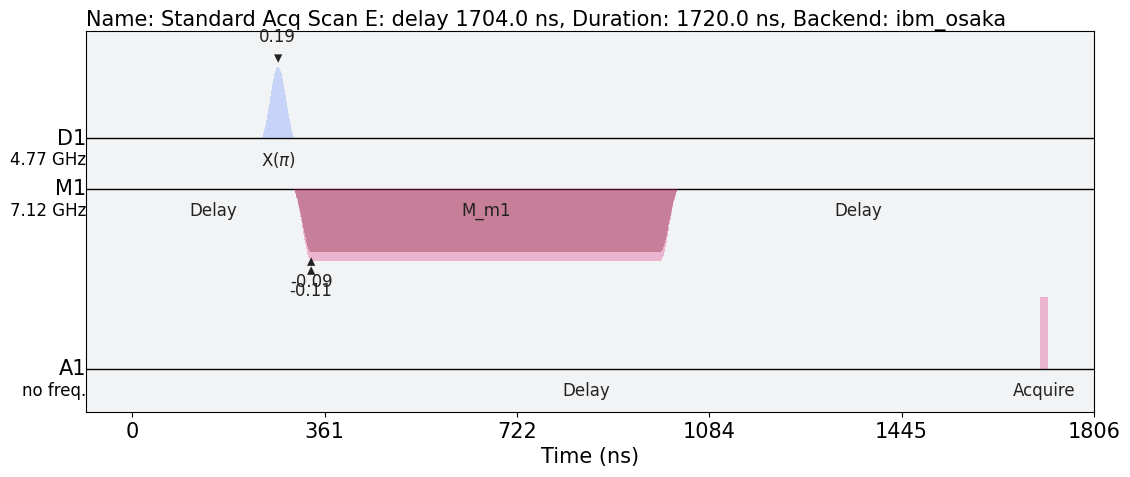

In [10]:
acq_jobs[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Measuring Photon Population using AC Stark Shift

In [12]:
center_freq = -10.0 * MHz
freq_span = 40.0 * MHz
num_exps = 126
ac_freq_linspace = np.linspace(-0.5 * freq_span, 0.5 * freq_span, num_exps) + center_freq

reset_delay_dt = measure_delay.duration

print(ac_freq_linspace/MHz)

[-30.   -29.68 -29.36 -29.04 -28.72 -28.4  -28.08 -27.76 -27.44 -27.12
 -26.8  -26.48 -26.16 -25.84 -25.52 -25.2  -24.88 -24.56 -24.24 -23.92
 -23.6  -23.28 -22.96 -22.64 -22.32 -22.   -21.68 -21.36 -21.04 -20.72
 -20.4  -20.08 -19.76 -19.44 -19.12 -18.8  -18.48 -18.16 -17.84 -17.52
 -17.2  -16.88 -16.56 -16.24 -15.92 -15.6  -15.28 -14.96 -14.64 -14.32
 -14.   -13.68 -13.36 -13.04 -12.72 -12.4  -12.08 -11.76 -11.44 -11.12
 -10.8  -10.48 -10.16  -9.84  -9.52  -9.2   -8.88  -8.56  -8.24  -7.92
  -7.6   -7.28  -6.96  -6.64  -6.32  -6.    -5.68  -5.36  -5.04  -4.72
  -4.4   -4.08  -3.76  -3.44  -3.12  -2.8   -2.48  -2.16  -1.84  -1.52
  -1.2   -0.88  -0.56  -0.24   0.08   0.4    0.72   1.04   1.36   1.68
   2.     2.32   2.64   2.96   3.28   3.6    3.92   4.24   4.56   4.88
   5.2    5.52   5.84   6.16   6.48   6.8    7.12   7.44   7.76   8.08
   8.4    8.72   9.04   9.36   9.68  10.  ]


126


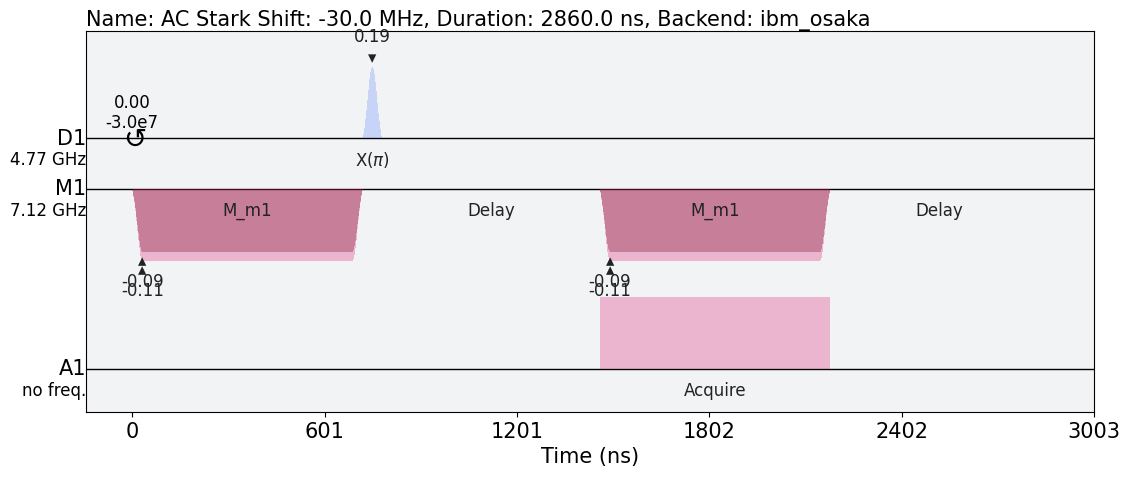

In [17]:
ac_freq_jobs = []

for freq_shift in ac_freq_linspace:
    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f'AC Stark Shift: {np.round(freq_shift/MHz, 1)} MHz'
    ) as ac_freq_sched:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)

        pulse.shift_frequency(freq_shift, qubit_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.play(x_pulse, qubit_chan)
        pulse.delay(reset_delay_dt, meas_chan)
        pulse.measure(qubit, pulse.MemorySlot(qubit))
    
    ac_freq_jobs.append(ac_freq_sched)

print(len(ac_freq_jobs))

ac_freq_jobs[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## Combining all Jobs and Running

In [18]:
from utils import acquisition_checker

normal_acq_job = chi_jobs + meas_jobs + ac_freq_jobs
low_acq_job = acq_jobs

num_shots = 8192
rep_delay = 499. * us

acquisition_checker(normal_acq_job, backend)
acquisition_checker(low_acq_job, backend)

print(len(normal_acq_job))
print(len(low_acq_job))

290
282


In [19]:
# Running normal_acq_job, low_acq_job

job_experiment = backend.run(normal_acq_job, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [ ]:
job_1 = provider.backend.retrieve_job(job_id='crwqn2c7wv80008fhzfg') # CANCELLED
job_2 = provider.backend.retrieve_job(job_id='crwpdyz7wv80008fhv80') # CANCELLED